<a href="https://colab.research.google.com/github/oanumnu/MIS-64061_oanumnu./blob/main/RNN_to_text_and_sequence_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.4.3'

Using Pretrained word embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, shutil

In [ ]:
imdb_dir = '/content/drive/MyDrive/aclImdb'
!ls '/content/drive/MyDrive/aclImdb'

 imdbEr.txt   imdb.vocab  'New Text Document.txt'   README   test   train


Import data

In [ ]:
import os

train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

Tokenize the data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 150
training_samples = 100
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


import glove 6b

In [ ]:
glove_dir = '/content/drive/MyDrive/glove.6B'
!ls '/content/drive/MyDrive/glove.6B'

glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


Preprocess embeddings

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector

Build the model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                480032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,480,065
Trainable params: 1,480,065
Non-trainable params: 0
_________________________________________________________________


Load the glove embeddings

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Train and evaluate

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
4/4 [==============================] - 2s 296ms/step - loss: 2.2054 - acc: 0.5862 - val_loss: 0.7813 - val_acc: 0.5094
Epoch 2/10
4/4 [==============================] - 1s 223ms/step - loss: 0.6062 - acc: 0.6652 - val_loss: 0.6983 - val_acc: 0.5461
Epoch 3/10
4/4 [==============================] - 1s 222ms/step - loss: 0.3793 - acc: 0.8010 - val_loss: 0.9853 - val_acc: 0.5008
Epoch 4/10
4/4 [==============================] - 1s 237ms/step - loss: 0.1717 - acc: 0.9536 - val_loss: 1.4688 - val_acc: 0.5004
Epoch 5/10
4/4 [==============================] - 1s 248ms/step - loss: 0.3316 - acc: 0.7941 - val_loss: 0.7181 - val_acc: 0.5312
Epoch 6/10
4/4 [==============================] - 1s 240ms/step - loss: 0.0996 - acc: 0.9845 - val_loss: 0.9061 - val_acc: 0.5059
Epoch 7/10
4/4 [==============================] - 1s 247ms/step - loss: 0.0637 - acc: 1.0000 - val_loss: 0.7631 - val_acc: 0.5275
Epoch 8/10
4/4 [==============================] - 1s 231ms/step - loss: 0.0462 - acc: 1.00

Plotting

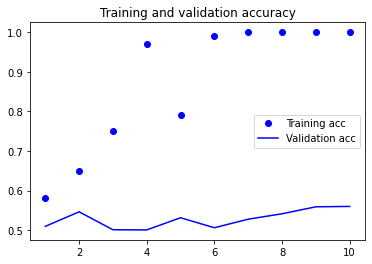

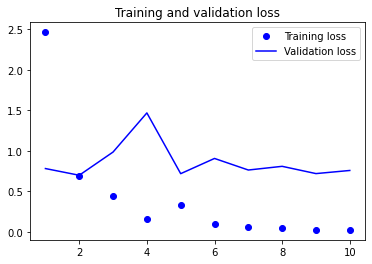

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

highest validation accuracy is 56% while training accuracy is 100%. model is overfitting

Training the model with an embedding layer

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,480,065
Trainable params: 1,480,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4/4 [==============================] - 2s 293ms/step - loss: 0.6990 - acc: 0.4752 - val_loss: 0.6924 - val_acc: 0.5119
Epoch 2/10
4/4 [==============================] - 1s 240ms/step - loss: 0.5086 - acc: 0.9661 - val_loss: 0.6925 

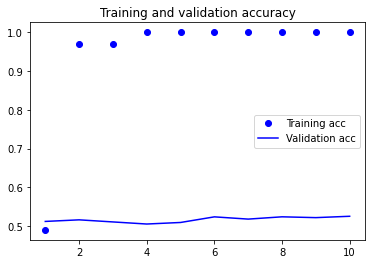

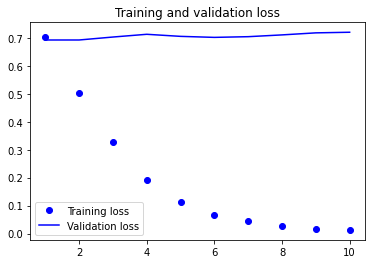

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Evaluate the model on the test set

Tokenize the data

In [ ]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Evaluate the model

In [ ]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.7657 - acc: 0.5491


[0.7656670808792114, 0.5491200089454651]

validation accuracy is 54%

Validation accuracy from pretrained word embedding is 56%, while accuracy using an embedding layer is 54%. we got a slightly higher accuracy from pretrained word embedding. 